In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

## Redução de linhas por modelo

In [3]:
def count_lines_by_file(base_dir='filtering'):
    records = []
    for model_name in os.listdir(base_dir):
        model_dir = os.path.join(base_dir, model_name)
        if not os.path.isdir(model_dir):
            continue

        for scenario_dir in os.listdir(model_dir):
            if not scenario_dir.startswith('scenario'):
                continue
            scenario_path = os.path.join(model_dir, scenario_dir)
            if not os.path.isdir(scenario_path):
                continue

            for filename in os.listdir(scenario_path):
                if not filename.endswith('.jsonl'):
                    continue
                file_path = os.path.join(scenario_path, filename)
                with open(file_path, 'r', encoding='utf-8') as f:
                    line_count = sum(1 for _ in f)
                records.append({
                    'grupo': model_name,
                    'cenario': scenario_dir,
                    'arquivo': filename,
                    'quantidade_linhas': line_count
                })

    return pd.DataFrame(records)

models_lines = count_lines_by_file()
grupo_cenario = models_lines.groupby(['grupo','cenario'])['quantidade_linhas'].sum().reset_index()

soma_por_cenario = grupo_cenario.groupby('grupo')['quantidade_linhas'].sum()
total_grupo = soma_por_cenario.reset_index()

linhas_eventos = total_grupo.loc[total_grupo['grupo'] == 'events', 'quantidade_linhas'].values[0]
total_grupo['diferenca'] = linhas_eventos - total_grupo['quantidade_linhas']

print("Soma dos cenários:")
display(total_grupo)

Soma dos cenários:


,grupo,quantidade_linhas,diferenca
0,events,3725,0
1,gemma2_2b,3669,56
2,llama3.2_3b,1648,2077
3,phi,1505,2220
4,tinyllama_1.1b,2852,873


## Tempo medio de cada modelo por fontes

In [4]:
files = glob.glob(f'logs/*.jsonl')

time = []
for file in files:
    model = pd.read_json(file, orient='records', lines=True)
    model = model[model['file'] != '']
    time.append(model.groupby(['model', 'mode', 'file', 'analysis'])['duration_seconds'].mean())

duration = pd.concat(time).reset_index()

duration_inference = duration[duration['mode'] == 'inference']
duration_filtering = duration[duration['mode'] == 'filtering']

grupo_inference = duration_inference.groupby('model')[['model', 'mode', 'file', 'duration_seconds', 'analysis']]
grupo_filtering = duration_filtering.groupby('model')[['model', 'mode', 'file', 'duration_seconds']]

models_inference = []
for _, grupo_df in grupo_inference:
    grupo_df['fonte'] = grupo_df['file'].str.extract(r'^([^/]+(?:/[^/]+)?)')
    grupo_df['fonte'] = grupo_df['fonte'].str.replace(r'filtering[/\\]|/scenario\d', '', regex=True)
    grupo_df.drop('file', axis=1, inplace=True)
    grupo_df = grupo_df.groupby(['model', 'mode', 'fonte'])['duration_seconds'].mean().reset_index()
    grupo_df = grupo_df.sort_values('duration_seconds').reset_index(drop=True)
    models_inference.append(grupo_df)

models_filtering = []
for _, grupo_df in grupo_filtering:
    grupo_df['fonte'] = grupo_df['file'].str.extract(r'^([^/]+(?:/[^/]+)?)')
    grupo_df['fonte'] = grupo_df['fonte'].str.replace(r'filtering[/\\]|/scenario\d', '', regex=True)
    grupo_df.drop('file', axis=1, inplace=True)
    grupo_df = grupo_df.groupby(['model', 'mode', 'fonte'])['duration_seconds'].mean().reset_index()
    grupo_df = grupo_df.sort_values('duration_seconds').reset_index(drop=True)
    models_filtering.append(grupo_df)

models_filtering = pd.concat(models_filtering).sort_values('duration_seconds')
models_inferencia = pd.concat(models_inference).sort_values(['duration_seconds'])

display(models_filtering)
display(models_inferencia)

,model,mode,fonte,duration_seconds
0,llama3.2:3b,filtering,events,0.052286
0,gemma2:2b,filtering,events,0.080654
0,tinyllama:1.1b,filtering,events,0.387482
0,phi,filtering,events,1.607919


,model,mode,fonte,duration_seconds
0,llama3.1,inference,llama3.2_3b,8.992035
1,llama3.1,inference,phi,9.077202
2,llama3.1,inference,tinyllama_1.1b,9.202919
3,llama3.1,inference,events,9.668781
4,llama3.1,inference,gemma2_2b,9.705937
0,mistral-nemo,inference,tinyllama_1.1b,12.253388
1,mistral-nemo,inference,phi,12.322464
2,mistral-nemo,inference,llama3.2_3b,12.445858
3,mistral-nemo,inference,events,12.814788
4,mistral-nemo,inference,gemma2_2b,12.934881


## Precisão dos modelos por fontes

In [8]:
files = glob.glob(f'logs/*.jsonl')

time = []
for file in files:
    model = pd.read_json(file, orient='records', lines=True)
    model = model[model['file'] != '']
    time.append(model.groupby(['model', 'mode', 'file', 'analysis'])['duration_seconds'].mean())

duration = pd.concat(time).reset_index()

duration_inference = duration[duration['mode'] == 'inference']

grupo_inference = duration_inference.groupby('model')[['model', 'mode', 'file', 'duration_seconds', 'analysis']]

models_inference = []
for _, grupo_df in grupo_inference:
    grupo_df['analysis'] = grupo_df['analysis'].str.replace(r'(?s)<think>.*?<\/think>', '', regex=True) # remover deepseek <think> 
    grupo_df['fonte'] = grupo_df['file'].str.replace(r'^filtering[/\\]', '', regex=True)
    grupo_df['model_font'] = grupo_df['fonte'].str.replace(r'/scenario\d|[/\\]\d+_\d+\.jsonl$', '', regex=True)
    grupo_df['fonte'] = grupo_df['fonte'].str.replace(r'^(.*?)(?=scenario)', '', regex=True)
    grupo_df.drop('file', axis=1, inplace=True)
    models_inference.append(grupo_df)

inference = []
for model in models_inference:
    model['analysis'] = model['analysis'].apply(
        lambda x: 'NOT INTERESTING' if 'NOT INTERESTING' in x else 'INTERESTING'
    )
    analise_int = model[model['analysis'] == 'INTERESTING']
    analise_nint = model[model['analysis'] == 'NOT INTERESTING']

    soma_int = analise_int.groupby(['model', 'model_font', 'fonte']).size()
    soma_nint = analise_nint.groupby(['model','model_font', 'fonte']).size()

    soma_int = pd.DataFrame(soma_int).reset_index().rename(columns={0:"quantidade"})
    soma_nint = pd.DataFrame(soma_nint).reset_index().rename(columns={0:"quantidade"})
    total = pd.merge(soma_int, soma_nint, on=['model_font', 'fonte'], how='outer', suffixes=('_int', '_nint'))
    total.drop(columns='model_nint', inplace=True)
    total = total.fillna(0)

    total['porcentagem_int'] = total['quantidade_int']/(total['quantidade_int'] + total['quantidade_nint']) * 100

    def calcular_erro(row):
        if 'scenario6' in row['fonte']:
            # Se for scenario6 e a porcentagem >= 50, ele errou
            return 'FALSO POSITIVO' if row['porcentagem_int'] >= 50 else 'VERDADEIRO NEGATIVO'
        else:
            # Caso contrário, se a porcentagem >= 50, ele acertou
            return 'VERDADEIRO POSITIVO' if row['porcentagem_int'] >= 50 else 'FALSO NEGATIVO'

    total['resultado'] = total.apply(calcular_erro, axis=1)
    total['model_int'] = total['model_int'].replace(0, total['model_int'].iloc[0])
    inference.append(total)

juntar = []
for inf in inference:
    grupo = inf.groupby(['model_font'])['resultado'].value_counts().reset_index()
    grupo['model'] = inf['model_int'].iloc[0]
    
    resultado_pivot = grupo.pivot_table(index=['model_font', 'model'], 
                                    columns='resultado', 
                                    values='count', 
                                    aggfunc='sum', 
                                    fill_value=0).reset_index()

    # Renomeando as colunas para deixar mais claro
    resultado_pivot.columns.name = None  # Remove o nome do índice das colunas
    resultado_pivot = resultado_pivot.rename(columns={'FALSO POSITIVO': 'falso_positivo', 'VERDADEIRO NEGATIVO': 'verdadeiro_negativo', 'VERDADEIRO POSITIVO': 'verdadeiro_positivo', 'FALSO NEGATIVO': 'falso_negativo'})

    # Exibir o resultado final
    juntar.append(resultado_pivot)
    display(resultado_pivot)
    

,model_font,model,falso_negativo,falso_positivo,verdadeiro_negativo,verdadeiro_positivo
0,events,deepseek-r1,13,3,2,19
1,gemma2_2b,deepseek-r1,16,3,2,16
2,llama3.2_3b,deepseek-r1,10,3,2,22
3,phi,deepseek-r1,15,2,3,17
4,tinyllama_1.1b,deepseek-r1,9,2,3,23


,model_font,model,falso_negativo,falso_positivo,verdadeiro_negativo,verdadeiro_positivo
0,events,gemma2,3,3,2,29
1,gemma2_2b,gemma2,3,3,2,29
2,llama3.2_3b,gemma2,4,3,2,28
3,phi,gemma2,6,2,3,26
4,tinyllama_1.1b,gemma2,4,3,2,28


,model_font,model,falso_positivo,verdadeiro_positivo
0,events,llama3.1,5,32
1,gemma2_2b,llama3.1,5,32
2,llama3.2_3b,llama3.1,5,32
3,phi,llama3.1,5,32
4,tinyllama_1.1b,llama3.1,5,32


,model_font,model,falso_positivo,verdadeiro_negativo,verdadeiro_positivo
0,events,mistral-nemo,3,2,32
1,gemma2_2b,mistral-nemo,4,1,32
2,llama3.2_3b,mistral-nemo,5,0,32
3,phi,mistral-nemo,4,1,32
4,tinyllama_1.1b,mistral-nemo,4,1,32


,model_font,model,falso_positivo,verdadeiro_negativo,verdadeiro_positivo
0,events,phi4:14b,3,2,32
1,gemma2_2b,phi4:14b,3,2,32
2,llama3.2_3b,phi4:14b,3,2,32
3,phi,phi4:14b,3,2,32
4,tinyllama_1.1b,phi4:14b,3,2,32


## Gerar gráficos

### Diminuição de Logs

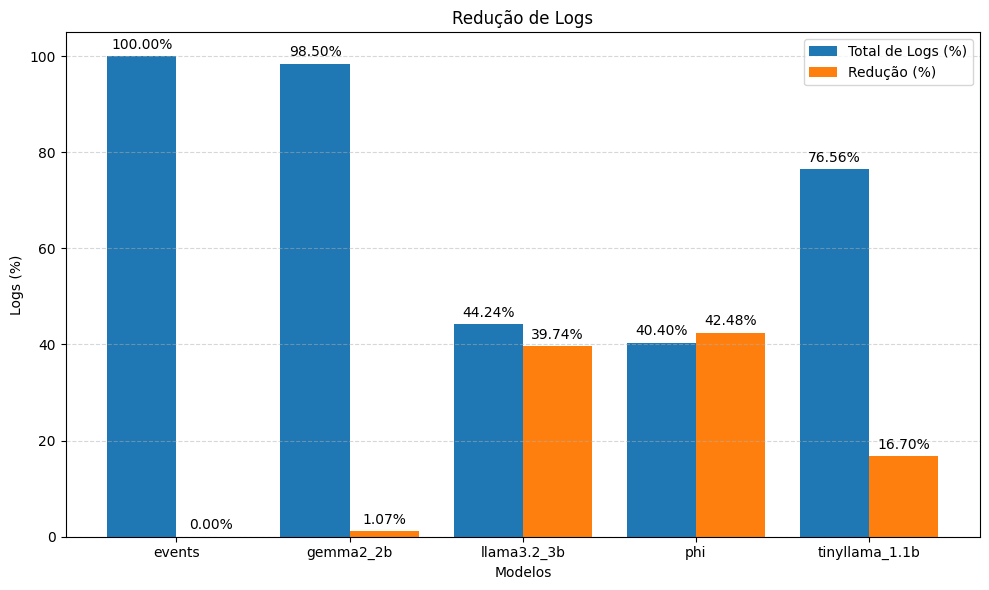

In [ ]:
df = pd.DataFrame(total_grupo)

total_quantidade = 3725
total_diferenca = df['diferenca'].sum()

df['quantidade_linhas_pct'] = df['quantidade_linhas'] / total_quantidade * 100
df['diferenca_pct'] = df['diferenca'] / total_quantidade * 100

# Criar o gráfico
plt.figure(figsize=(10, 6))
bar_width = 0.4

# Posições das barras
r1 = range(len(df))
r2 = [x + bar_width for x in r1]

bars1 = plt.bar(r1, df['quantidade_linhas_pct'], width=bar_width, label='Total de Logs (%)')
bars2 = plt.bar(r2, df['diferenca_pct'], width=bar_width, label='Redução (%)')

# Personalizar
plt.xlabel('Modelos')
plt.ylabel('Logs (%)')
plt.title('Redução de Logs')
plt.xticks([r + bar_width / 2 for r in range(len(df))], df['grupo'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.bar_label(bars1, fmt='%.2f%%', padding=3)
plt.bar_label(bars2, fmt='%.2f%%', padding=3)

plt.tight_layout()
plt.savefig('result/reducao_log.png')
plt.show()

### Tempo de filtragem

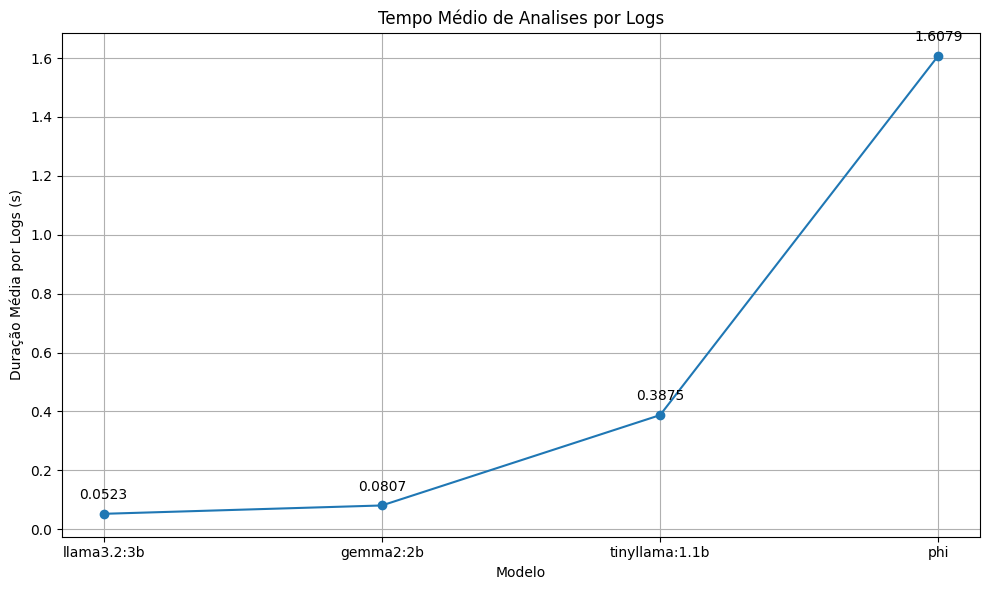

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Dados
df = pd.DataFrame(models_filtering.reset_index(drop=True))

# Criar o gráfico de linhas
plt.figure(figsize=(10, 6))

# Aqui criamos a posição numérica
x = range(len(df))

plt.plot(x, df['duration_seconds'], marker='o')
plt.xticks(x, df['model'])

# Adicionando os valores
for i, txt in enumerate(df['duration_seconds']):
    plt.text(i, df['duration_seconds'][i] + 0.05, f'{txt:.4f}', ha='center')

# Personalizar
plt.xlabel('Modelo')
plt.ylabel('Duração Média por Logs (s)')
plt.title('Tempo Médio de Analises por Logs')
plt.grid(True)
plt.tight_layout()

plt.savefig('result/tempo_por_log')
plt.show()

### Tempo de Analise

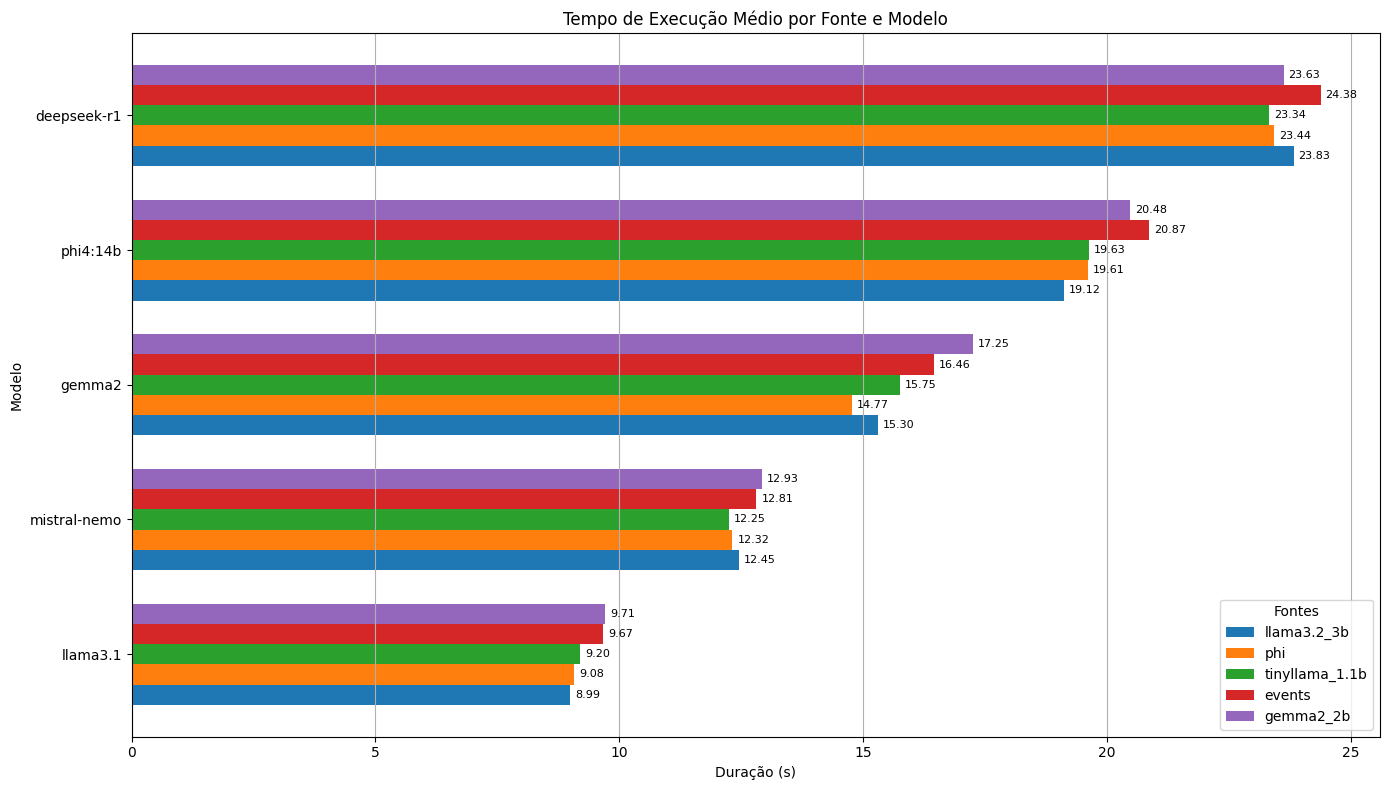

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.DataFrame(models_inferencia).reset_index(drop=True)

# Pegar fontes e modelos únicos
fontes = df['fonte'].unique()
modelos = df['model'].unique()

# Configurar
y = np.arange(len(modelos))  # posição dos modelos no eixo Y
largura = 0.15  # largura de cada barra

plt.figure(figsize=(14, 8))

# Para cada fonte, desenhar as barras
for i, fonte in enumerate(fontes):
    df_fonte = df[df['fonte'] == fonte]
    barras = plt.barh(y + i*largura, df_fonte['duration_seconds'], height=largura, label=fonte)
    
    # Adicionar o valor ao lado de cada barra
    for bar in barras:
        largura_barra = bar.get_width()
        plt.text(
            largura_barra + 0.1,  # posição x (um pouco à direita da barra)
            bar.get_y() + bar.get_height()/2,  # posição y (centro da barra)
            f'{largura_barra:.2f}',  # valor formatado
            va='center', fontsize=8
        )

# Personalizar
plt.ylabel('Modelo')
plt.xlabel('Duração (s)')
plt.title('Tempo de Execução Médio por Fonte e Modelo')
plt.yticks(y + largura * (len(fontes)-1)/2, modelos)
plt.legend(title='Fontes')
plt.grid(axis='x')
plt.tight_layout()

plt.savefig('result/tempo_inferencia_por_fonte')
plt.show()


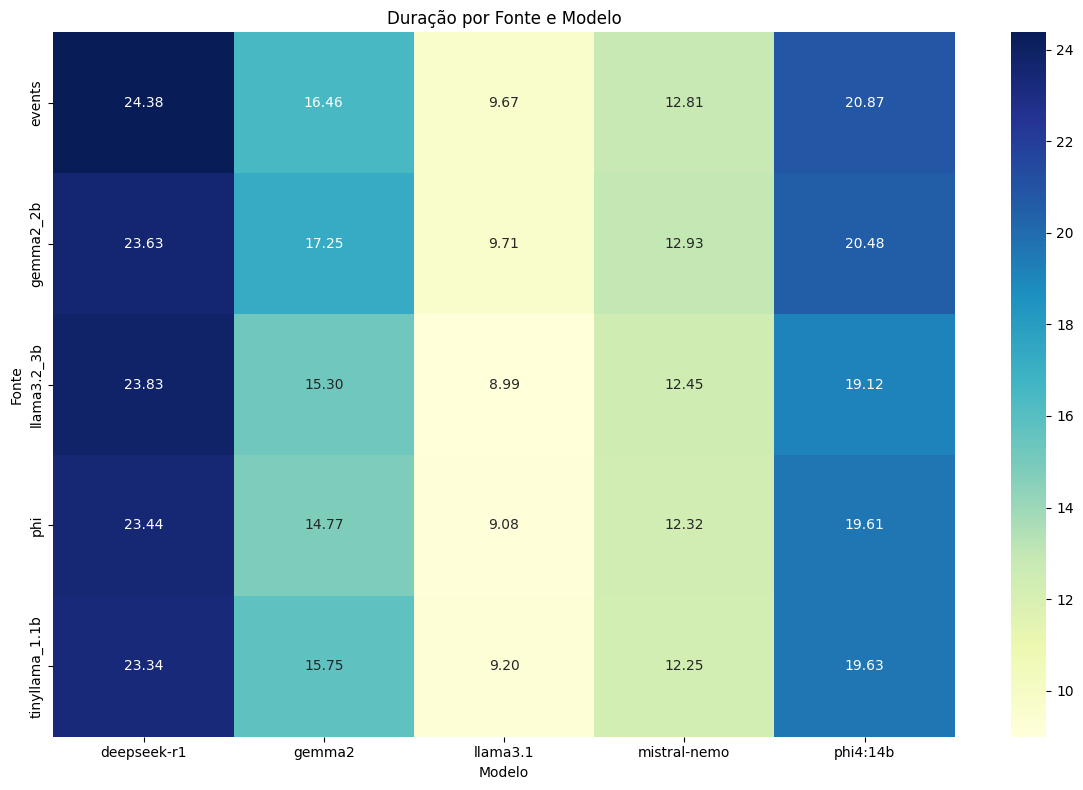

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivotar o DataFrame para o formato de tabela
pivot = df.pivot(index='fonte', columns='model', values='duration_seconds')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")

plt.title('Duração por Fonte e Modelo')
plt.ylabel('Fonte')
plt.xlabel('Modelo')
plt.tight_layout()
plt.show()


### Inferencias

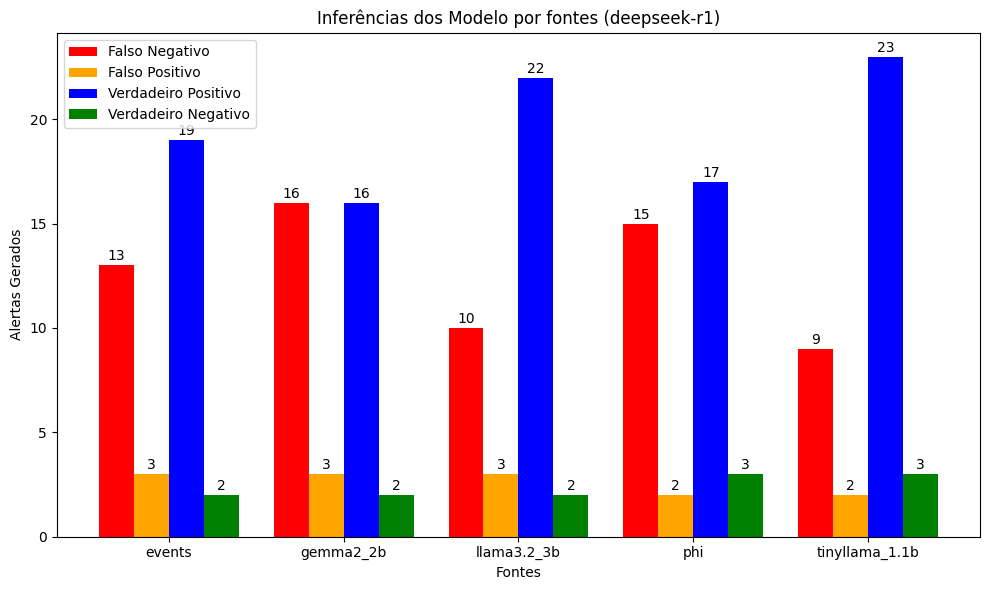

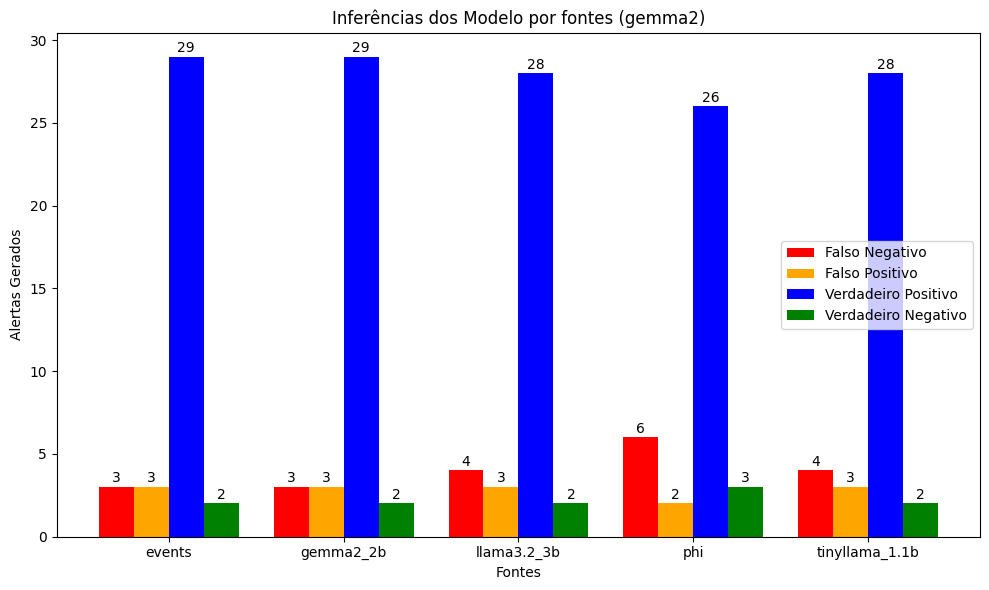

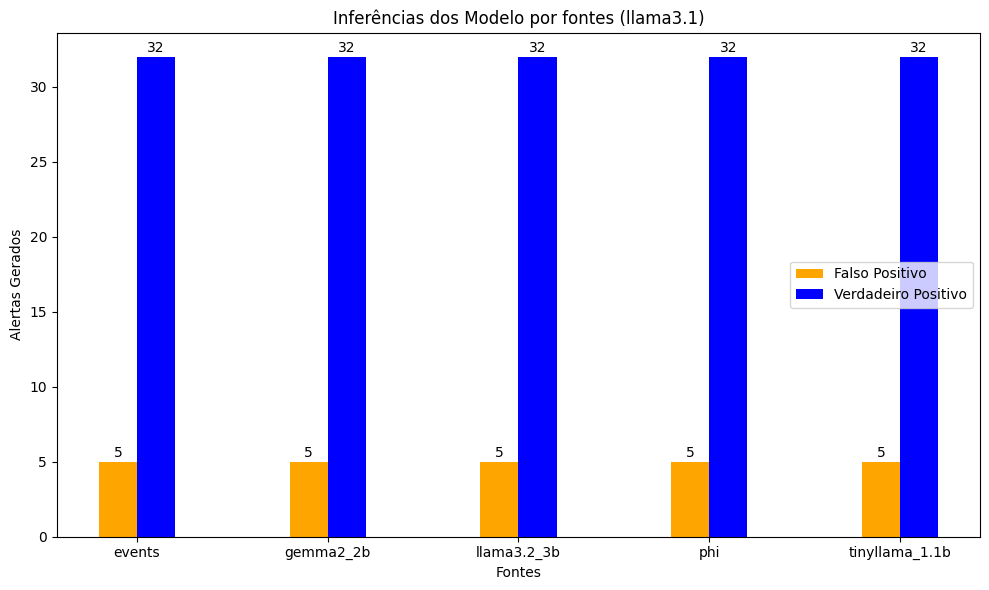

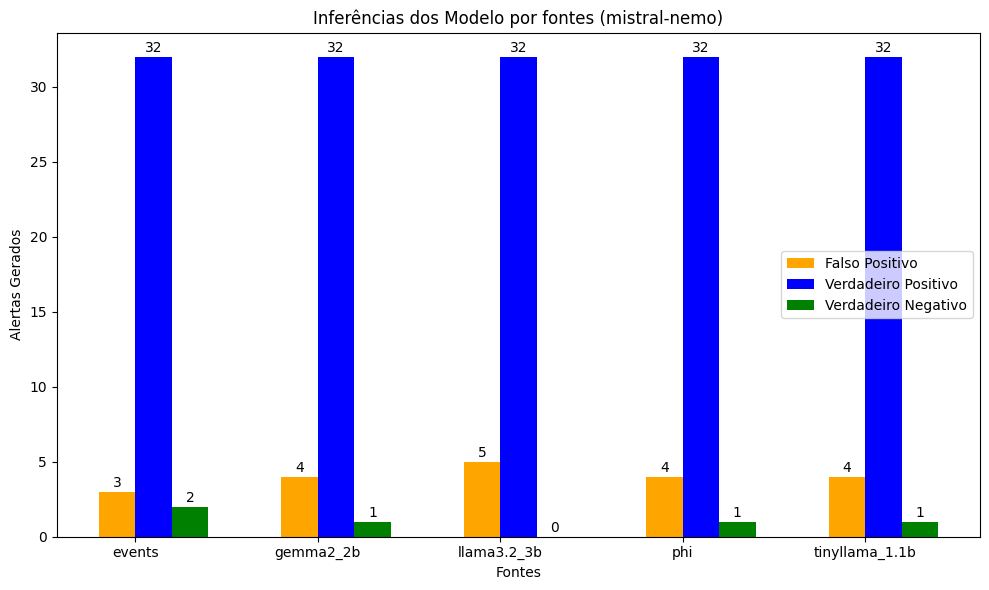

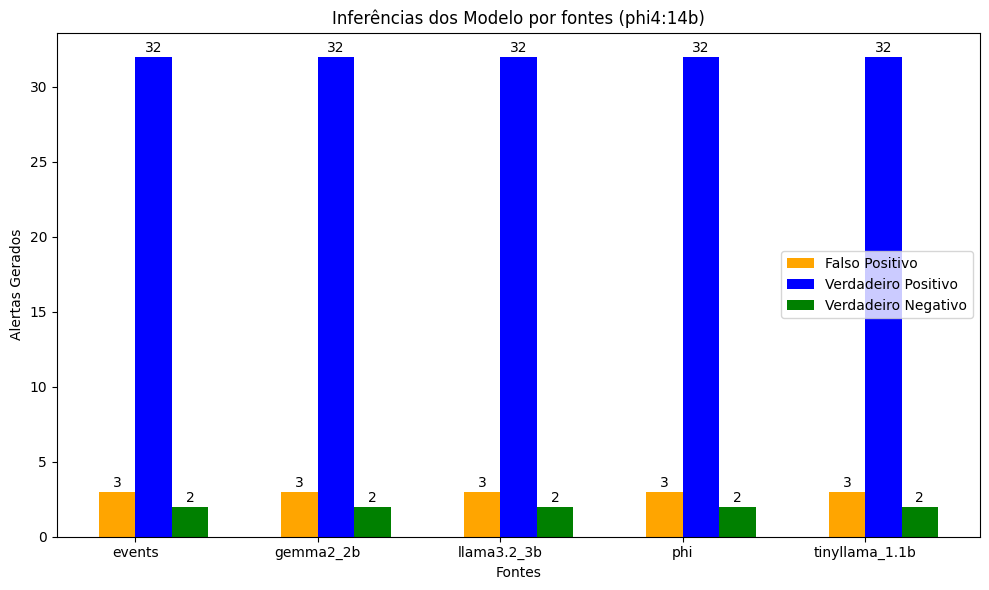

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Gerar um gráfico separado para cada DataFrame
for i, df in enumerate(juntar):
    # Posição das barras
    bar_width = 0.2
    index = np.arange(len(df))

    # Criar o gráfico
    fig, ax = plt.subplots(figsize=(10, 6))

    # Criar as barras para cada métrica
    if 'falso_negativo' in df.columns:
        bars_fn = ax.bar(index, df['falso_negativo'], bar_width, label='Falso Negativo', color='red')
        for bar in bars_fn:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.1,  # Posição do texto
                    f'{height}', ha='center', va='bottom', fontsize=10)

    if 'falso_positivo' in df.columns:
        bars_fp = ax.bar(index + 1 * bar_width, df['falso_positivo'], bar_width, label='Falso Positivo', color='orange')
        for bar in bars_fp:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.1,  # Posição do texto
                    f'{height}', ha='center', va='bottom', fontsize=10)

    if 'verdadeiro_positivo' in df.columns:
        bars_vp = ax.bar(index + 2 * bar_width, df['verdadeiro_positivo'], bar_width, label='Verdadeiro Positivo', color='blue')
        for bar in bars_vp:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.1,  # Posição do texto
                    f'{height}', ha='center', va='bottom', fontsize=10)
            
    if 'verdadeiro_negativo' in df.columns:
        bars_vn = ax.bar(index + 3 * bar_width, df['verdadeiro_negativo'], bar_width, label='Verdadeiro Negativo', color='green')
        for bar in bars_vn:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.1,  # Posição do texto
                    f'{height}', ha='center', va='bottom', fontsize=10)

    # Personalizar o gráfico
    ax.set_xlabel('Fontes')
    ax.set_ylabel('Alertas Gerados')
    ax.set_title(f'Inferências dos Modelo por fontes ({df["model"].iloc[0]})')
    ax.set_xticks(index + 1.5 * bar_width)
    ax.set_xticklabels(df['model_font'])
    ax.legend()

    # Exibir o gráfico
    plt.tight_layout()
    plt.savefig(f'result/inferencia_{df["model"].iloc[0].replace(':', '_')}.png')
    plt.show()
